# 08 - Blackbox Optimization Benchmarking Problem [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/08_bbo_visualize.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX on NVIDIA GPU with:

In [ ]:
%pip install -U "jax[cuda]"

Then, install `evosax` from PyPi:

In [ ]:
%pip install -U "evosax[examples]"

## Import

In [30]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mediapy
from evosax import CMA_ES
from evosax.problems import BBOBProblem as Problem
from evosax.problems import bbob_fns
from matplotlib.animation import FuncAnimation, PillowWriter

In [14]:
key = jax.random.key(0)

## Visualize BBOB functions

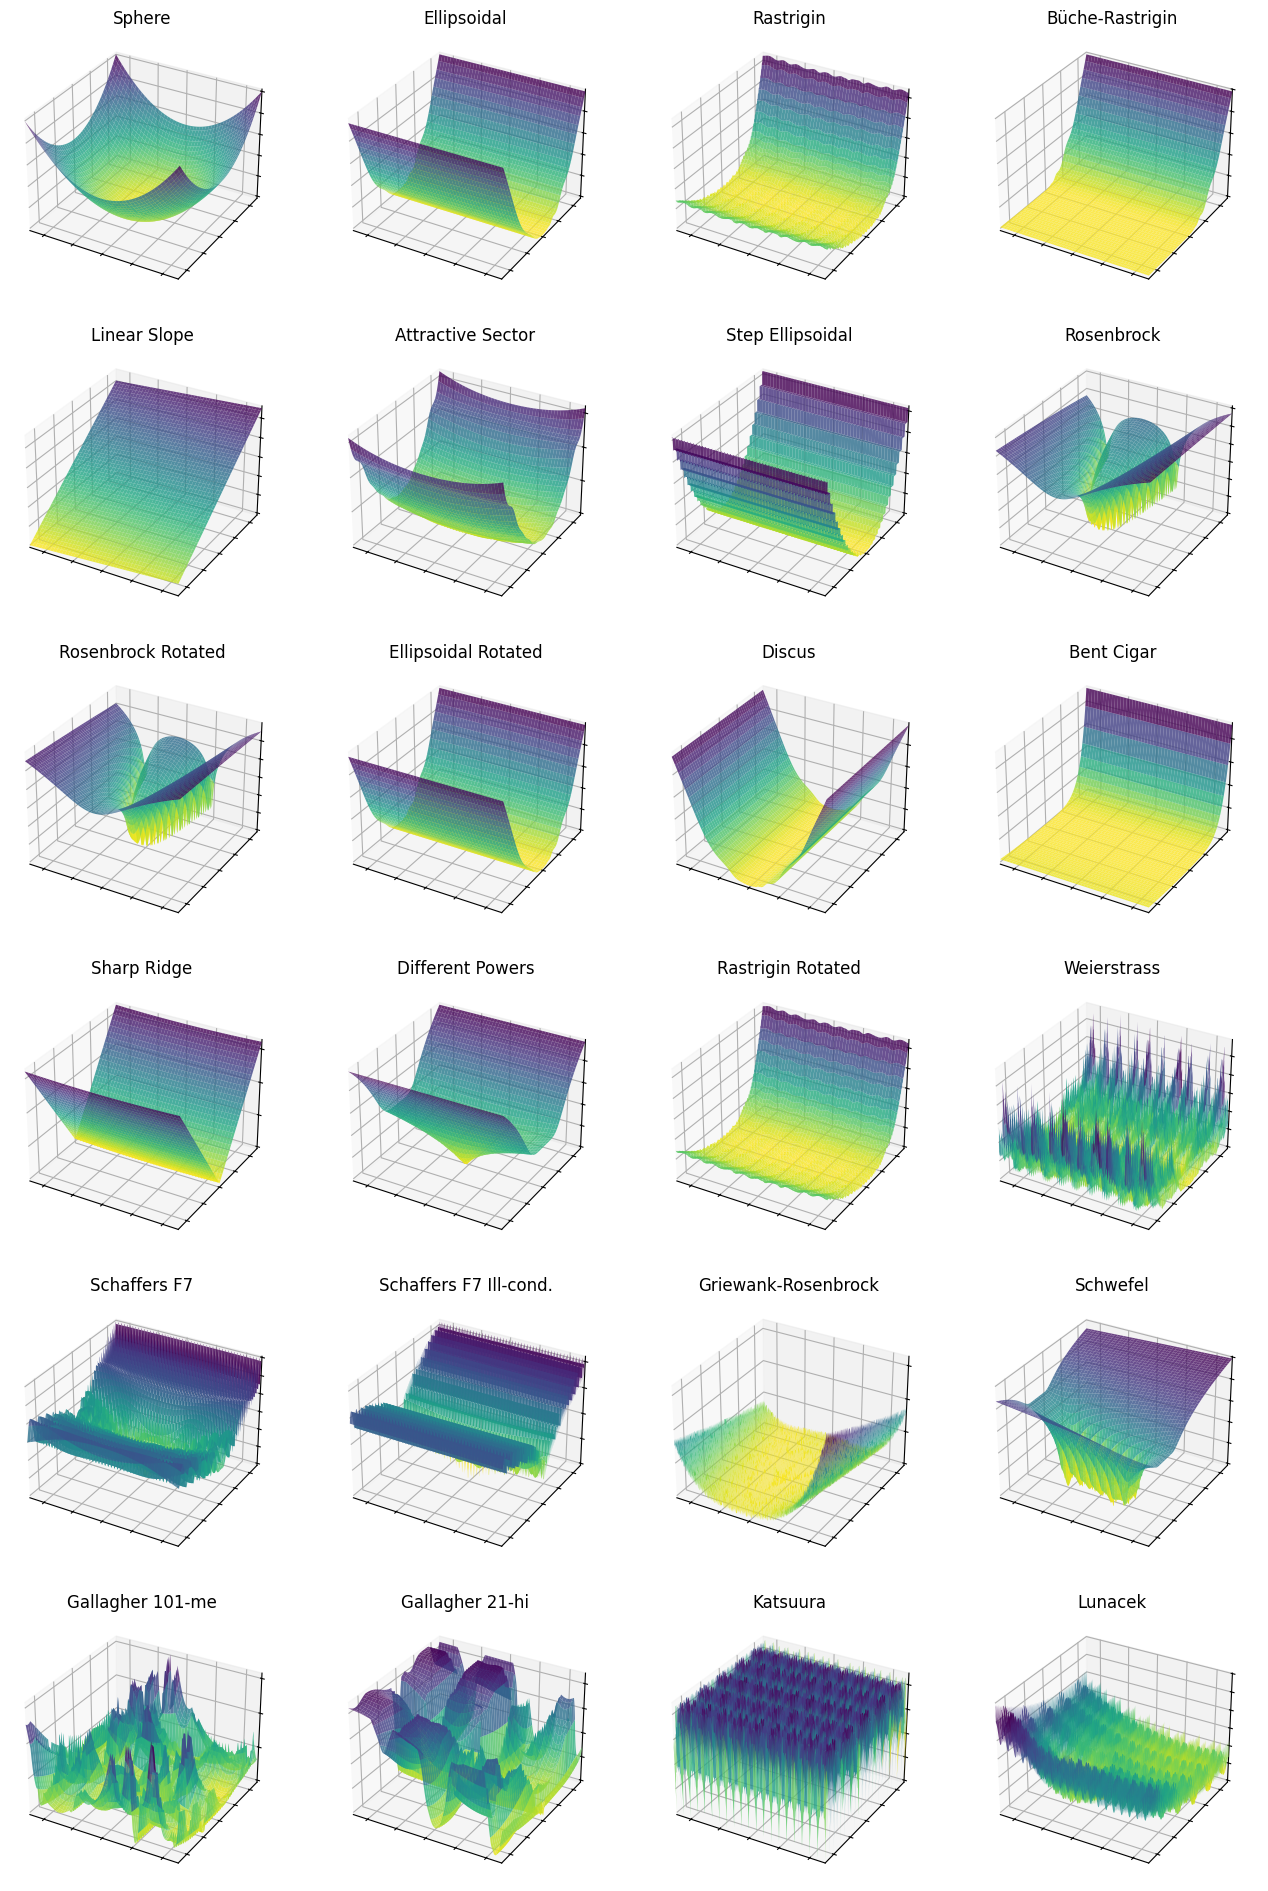

In [15]:
# Instantiates all BBOB problems
problems = {
    bbob_fn: Problem(
        fn_name=bbob_fn,
        num_dims=2,
        x_opt=jnp.array([0.0, 0.0]),
        f_opt=0.0,
        sample_rotations=False,
        noise_config={"noise_model_name": "noiseless", "use_stabilization": False},
    )
    for bbob_fn in bbob_fns
}

# List of functions to use logscale for
logscale_functions = [
    "rosenbrock",
    "rosenbrock_rotated",
    "different_powers",
    "schaffers_f7",
    "schaffers_f7_ill_cond",
    "schwefel",
    "katsuura",
]

# Create a figure with 6 rows and 4 columns
fig, axes = plt.subplots(6, 4, figsize=(16, 24), subplot_kw={"projection": "3d"})
axes = axes.flatten()

# Loop through all BBOB functions
for i, fn_name in enumerate(bbob_fns):
    # Get the problem for this function
    problem = problems[fn_name]

    # Plot the function on the corresponding axis
    key, subkey = jax.random.split(key)
    problem.visualize_3d(subkey, ax=axes[i], logscale=fn_name in logscale_functions)

    # Remove some elements to make the grid cleaner
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_zlabel("")

    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    axes[i].set_zticklabels([])

plt.tight_layout()
plt.show()

## Visualize optimization

### Instantiate optimization problem

In [15]:
problem = Problem(
    fn_name="rosenbrock",
    num_dims=2,
    x_opt=jnp.array([0.0, 0.0]),
    f_opt=0.0,
    sample_rotations=False,
    noise_config={"noise_model_name": "noiseless", "use_stabilization": False},
)

key, subkey = jax.random.split(key)
solution = problem.sample(subkey)

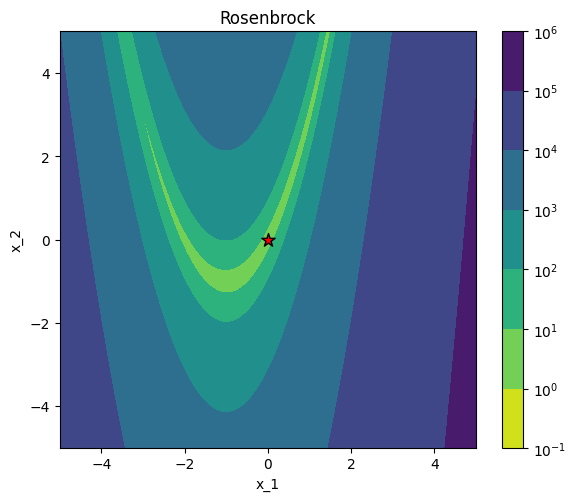

In [16]:
problem.visualize_2d(key, logscale=True)

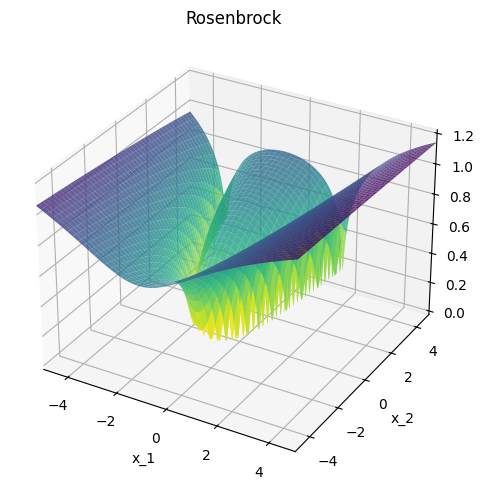

In [17]:
problem.visualize_3d(key, logscale=True)

### Instantiate CMA-ES

In [23]:
population_size = 16


def metrics_fn(key, population, fitness, state, params):
    """Compute metrics for evolution strategy."""
    idx = jnp.argmin(fitness)
    return {"best_fitness": fitness[idx], "mean": state.mean}


es = CMA_ES(
    population_size=population_size,
    solution=solution,
    metrics_fn=metrics_fn,
)

params = es.default_params

key, subkey = jax.random.split(key)
state = es.init(subkey, params)

state = state.replace(mean=solution)

### Run

In [24]:
def step(carry, _):
    key, state, params = carry
    key, key_ask, key_eval, key_tell = jax.random.split(key, 4)

    population, state = es.ask(key_ask, state, params)

    population = jnp.clip(population, -5, 5)
    fitness, _ = problem.eval(key_eval, population)

    state, metrics = es.tell(key_tell, population, fitness, state, params)

    return (key, state, params), metrics

In [25]:
num_generations = 64

_, metrics = jax.lax.scan(
    step,
    (key, state, params),
    length=num_generations,
)

### Visualize


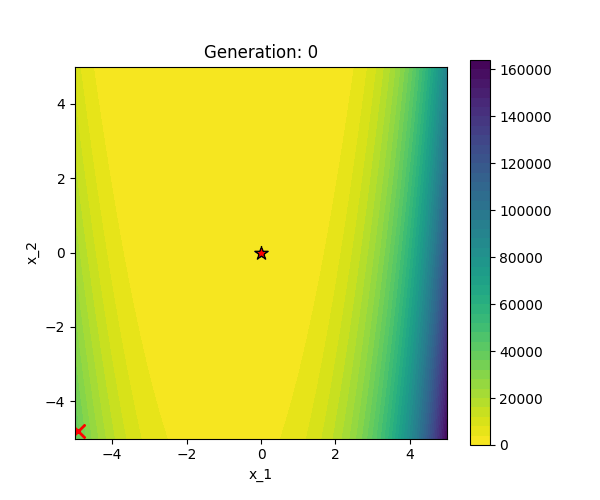

In [46]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Visualize the problem landscape
key, subkey = jax.random.split(key)
problem.visualize_2d(subkey, ax=ax)

# Extract mean trajectory from metrics
means = metrics["mean"]  # Shape: (num_generations, num_dims)

# Create a scatter plot for the current position
scatter = ax.scatter([], [], color="red", s=100, marker="x", linewidth=2)

# Add a title with generation counter
title = ax.set_title("Generation: 0")


def init():
    scatter.set_offsets(jnp.empty((0, 2)))
    return scatter, title


def update(frame):
    # Update the position of the mean
    scatter.set_offsets(means[frame].reshape(1, -1))

    # Update the title with current generation
    title.set_text(f"Generation: {frame}")

    return scatter, title


# Create the animation
anim = FuncAnimation(fig, update, frames=len(means), init_func=init, blit=True)

plt.close()

# Create a writer
path = "anim.gif"
anim.save(path, writer=PillowWriter())

# Display the GIF in the notebook
mediapy.show_video(mediapy.read_video(path), fps=20, codec="gif")